In [3]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [4]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
from tqdm.auto import tqdm

# Embeddings
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

print("✓ All imports successful")

✓ All imports successful


## 1. Load Topic Definitions and Embeddings

Load validated topic definitions and embeddings from 15a exploration.

In [5]:
# Paths
gold_submissions_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'submissions'
gold_comments_path = workspace_root / 'data' / '01_corpus' / '02_gold' / 'reddit' / 'comments'
topic_data_path = workspace_root / 'data' / '02_topics' / 'reddit'
output_path = workspace_root / 'data' / '02_topics' / 'reddit'
output_path.mkdir(parents=True, exist_ok=True)

print(f"Gold submissions: {gold_submissions_path}")
print(f"Gold comments: {gold_comments_path}")
print(f"Topic data: {topic_data_path}")
print(f"Output: {output_path}")

print(f"\nPaths exist:")
print(f"  Submissions: {gold_submissions_path.exists()}")
print(f"  Comments: {gold_comments_path.exists()}")
print(f"  Topic data: {topic_data_path.exists()}")

Gold submissions: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/02_gold/reddit/submissions
Gold comments: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/01_corpus/02_gold/reddit/comments
Topic data: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit
Output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit

Paths exist:
  Submissions: True
  Comments: True
  Topic data: True


In [6]:
# Load topic definitions
with open(topic_data_path / 'topic_definitions.json', 'r') as f:
    topic_definitions = json.load(f)

print("Loaded topic definitions:")
for topic_id, topic_info in topic_definitions.items():
    print(f"  {topic_id}: {topic_info['label']}")

# Load topic embeddings
embeddings_matrix = np.load(topic_data_path / 'topic_embeddings.npy')
with open(topic_data_path / 'topic_ids.json', 'r') as f:
    topic_ids = json.load(f)

# Create dictionary mapping topic_id -> embedding
topic_embeddings = {topic_id: embeddings_matrix[i] for i, topic_id in enumerate(topic_ids)}

print(f"\n✓ Loaded {len(topic_embeddings)} topic embeddings")
print(f"  Embedding dimension: {embeddings_matrix.shape[1]}")

Loaded topic definitions:
  climate_change: Climate Change
  donald_trump: Donald Trump
  gun_control: Gun Control
  immigration: Immigration
  vaccination: Vaccination

✓ Loaded 5 topic embeddings
  Embedding dimension: 384


In [7]:
# Load sentence embedding model (same as used in 15a)
print("Loading sentence embedding model...")
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)

print(f"✓ Loaded model: {model_name}")
print(f"  Embedding dimension: {model.get_sentence_embedding_dimension()}")
print(f"  Max sequence length: {model.max_seq_length}")

Loading sentence embedding model...
✓ Loaded model: sentence-transformers/all-MiniLM-L6-v2
  Embedding dimension: 384
  Max sequence length: 256


## 2. PART 1: Thread-Level Assignment (Submissions)

Load all submissions and assign topics based on submission content.

In [8]:
# Load all submissions
print("Loading all submissions...\n")

submission_files = sorted(gold_submissions_path.glob('*.parquet'))
print(f"Found {len(submission_files)} submission files")

submissions_list = []
for file in submission_files:
    df = read_parquet(file)
    submissions_list.append(df)
    print(f"  {file.name}: {len(df):,} submissions")

df_submissions = pd.concat(submissions_list, ignore_index=True)

print(f"\n✓ Total submissions loaded: {len(df_submissions):,}")
print(f"Columns: {df_submissions.columns.tolist()}")

Loading all submissions...

Found 2 submission files
  2016-09.parquet: 386,214 submissions
  2016-10.parquet: 537,217 submissions

✓ Total submissions loaded: 923,431
Columns: ['submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id', 'subreddit', 'num_comments']


In [9]:
# Prepare submission texts (title + selftext)
print("Preparing submission texts...")

submission_texts = (
    df_submissions['title'].fillna('') + ' ' + 
    df_submissions['selftext'].fillna('')
).tolist()

print(f"✓ Prepared {len(submission_texts):,} submission texts")
print(f"  Average length: {np.mean([len(t) for t in submission_texts]):.0f} characters")

Preparing submission texts...
✓ Prepared 923,431 submission texts
  Average length: 140 characters


In [13]:
# Embed all submissions (this will take some time)
print(f"\nEmbedding {len(submission_texts):,} submissions...")
print("This will take approximately 40-50 minutes...\n")

submission_embeddings = model.encode(
    submission_texts,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(f"\n✓ Created submission embeddings: {submission_embeddings.shape}")
print(f"  Memory usage: {submission_embeddings.nbytes / 1024 / 1024:.1f} MB")


Embedding 923,431 submissions...
This will take approximately 40-50 minutes...



Batches:   0%|          | 0/7215 [00:00<?, ?it/s]


✓ Created submission embeddings: (923431, 384)
  Memory usage: 1352.7 MB


In [14]:
# Calculate similarities for all topics
print("Computing submission-level topic similarities...\n")

for topic_id, topic_embedding in tqdm(topic_embeddings.items(), desc="Topics"):
    topic_label = topic_definitions[topic_id]['label']
    
    # Compute cosine similarity
    similarities = cosine_similarity(
        submission_embeddings, 
        topic_embedding.reshape(1, -1)
    ).flatten()
    
    # Add to dataframe
    df_submissions[f'sim_{topic_id}'] = similarities
    
    print(f"  {topic_label}:")
    print(f"    Mean: {similarities.mean():.3f}, Median: {np.median(similarities):.3f}")
    print(f"    > 0.4: {(similarities > 0.4).sum():,} ({(similarities > 0.4).sum()/len(similarities)*100:.1f}%)")

print(f"\n✓ Computed similarities for {len(topic_embeddings)} topics")

Computing submission-level topic similarities...



Topics:   0%|          | 0/5 [00:00<?, ?it/s]

  Climate Change:
    Mean: 0.060, Median: 0.056
    > 0.4: 3,222 (0.3%)
  Donald Trump:
    Mean: 0.221, Median: 0.217
    > 0.4: 79,644 (8.6%)
  Gun Control:
    Mean: 0.083, Median: 0.074
    > 0.4: 5,972 (0.6%)
  Immigration:
    Mean: 0.138, Median: 0.133
    > 0.4: 10,172 (1.1%)
  Vaccination:
    Mean: 0.078, Median: 0.076
    > 0.4: 337 (0.0%)

✓ Computed similarities for 5 topics


In [15]:
# Assign topics at thread level
THRESHOLD = 0.4  # Validated in 15a

print(f"Assigning topics to submissions (threshold = {THRESHOLD})...\n")

# Get all similarity columns
sim_cols = [f'sim_{topic_id}' for topic_id in topic_ids]

# Find max similarity and corresponding topic
df_submissions['max_similarity'] = df_submissions[sim_cols].max(axis=1)
df_submissions['best_topic_idx'] = df_submissions[sim_cols].idxmax(axis=1)

# Map back to topic ID
df_submissions['best_topic'] = df_submissions['best_topic_idx'].apply(
    lambda x: topic_ids[sim_cols.index(x)] if pd.notna(x) else None
)

# Apply threshold: assign topic only if similarity >= threshold
df_submissions['thread_topic'] = df_submissions.apply(
    lambda row: row['best_topic'] if row['max_similarity'] >= THRESHOLD else None,
    axis=1
)

# Statistics
print(f"Thread-level assignment results:")
print(f"  Submissions with topic: {df_submissions['thread_topic'].notna().sum():,} ({df_submissions['thread_topic'].notna().sum()/len(df_submissions)*100:.1f}%)")
print(f"  Submissions without topic: {df_submissions['thread_topic'].isna().sum():,} ({df_submissions['thread_topic'].isna().sum()/len(df_submissions)*100:.1f}%)")

print(f"\nTopic distribution:")
topic_counts = df_submissions['thread_topic'].value_counts()
for topic_id, count in topic_counts.items():
    topic_label = topic_definitions[topic_id]['label']
    pct = count / df_submissions['thread_topic'].notna().sum() * 100
    print(f"  {topic_label}: {count:,} ({pct:.1f}%)")

print(f"\n✓ Thread topics assigned to {len(df_submissions):,} submissions")

Assigning topics to submissions (threshold = 0.4)...

Thread-level assignment results:
  Submissions with topic: 98,178 (10.6%)
  Submissions without topic: 825,253 (89.4%)

Topic distribution:
  Donald Trump: 78,762 (80.2%)
  Immigration: 9,961 (10.1%)
  Gun Control: 5,925 (6.0%)
  Climate Change: 3,200 (3.3%)
  Vaccination: 330 (0.3%)

✓ Thread topics assigned to 923,431 submissions


In [16]:
# Save submissions with topics
submissions_output = output_path / 'submissions_with_topics_hybrid.parquet'

# Select columns to save
cols_to_save = [
    'submission_id', 'title', 'selftext', 'created_utc', 'subreddit_id',
    'subreddit', 'num_comments', 'thread_topic', 'max_similarity'
] + sim_cols

df_submissions[cols_to_save].to_parquet(submissions_output, index=False)

print(f"✓ Saved submissions with topics: {submissions_output}")
print(f"  Total submissions: {len(df_submissions):,}")
print(f"  With topics: {df_submissions['thread_topic'].notna().sum():,}")
print(f"  File size: {submissions_output.stat().st_size / 1024 / 1024:.1f} MB")

✓ Saved submissions with topics: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/submissions_with_topics_hybrid.parquet
  Total submissions: 923,431
  With topics: 98,178
  File size: 114.8 MB


## 3. PART 2: Comment-Level Filtering

Load all comments and apply hybrid filter (two-stage filtering).

In [17]:
# Load all comments
print("Loading all comments...\n")

comment_files = sorted(gold_comments_path.glob('*.parquet'))
print(f"Found {len(comment_files)} comment files")

comments_list = []
for file in comment_files:
    df = read_parquet(file)
    comments_list.append(df)
    print(f"  {file.name}: {len(df):,} comments")

df_comments = pd.concat(comments_list, ignore_index=True)

print(f"\n✓ Total comments loaded: {len(df_comments):,}")
print(f"Columns: {df_comments.columns.tolist()}")

Loading all comments...

Found 2 comment files
  2016-09.parquet: 3,766,133 comments
  2016-10.parquet: 4,932,790 comments

✓ Total comments loaded: 8,698,923
Columns: ['comment_id', 'submission_id', 'parent_id', 'created_utc', 'subreddit_id', 'subreddit', 'body']


In [18]:
# Step 1: Filter to comments in topic-assigned threads
print("Filtering comments to topic-assigned threads...\n")

# Get submission IDs with assigned topics
threads_with_topics = set(df_submissions[df_submissions['thread_topic'].notna()]['submission_id'])

print(f"Threads with topics: {len(threads_with_topics):,}")

# Filter comments
df_comments_filtered = df_comments[df_comments['submission_id'].isin(threads_with_topics)].copy()

print(f"\nComment filtering (Step 1):")
print(f"  Original comments: {len(df_comments):,}")
print(f"  In topic threads: {len(df_comments_filtered):,} ({len(df_comments_filtered)/len(df_comments)*100:.1f}%)")
print(f"  Reduction: {len(df_comments) - len(df_comments_filtered):,} ({(1 - len(df_comments_filtered)/len(df_comments))*100:.1f}%)")

print(f"\n✓ Filtered to {len(df_comments_filtered):,} comments in topic threads")

Filtering comments to topic-assigned threads...

Threads with topics: 98,178

Comment filtering (Step 1):
  Original comments: 8,698,923
  In topic threads: 1,281,542 (14.7%)
  Reduction: 7,417,381 (85.3%)

✓ Filtered to 1,281,542 comments in topic threads


In [19]:
# Merge thread topics onto comments
print("Merging thread topics onto comments...")

df_comments_filtered = df_comments_filtered.merge(
    df_submissions[['submission_id', 'thread_topic']],
    on='submission_id',
    how='left'
)

print(f"\n✓ Merged thread topics")
print(f"  Comments with thread_topic: {df_comments_filtered['thread_topic'].notna().sum():,}")

# Verify distribution
print(f"\nComments per topic (before individual filtering):")
for topic_id in topic_ids:
    count = (df_comments_filtered['thread_topic'] == topic_id).sum()
    topic_label = topic_definitions[topic_id]['label']
    print(f"  {topic_label}: {count:,}")

Merging thread topics onto comments...

✓ Merged thread topics
  Comments with thread_topic: 1,281,542

Comments per topic (before individual filtering):
  Climate Change: 33,369
  Donald Trump: 1,124,843
  Gun Control: 55,297
  Immigration: 67,221
  Vaccination: 812


In [20]:
# Prepare comment texts
print(f"Preparing {len(df_comments_filtered):,} comment texts...")

comment_texts = df_comments_filtered['body'].fillna('').tolist()

print(f"✓ Prepared comment texts")
print(f"  Average length: {np.mean([len(t) for t in comment_texts]):.0f} characters")

Preparing 1,281,542 comment texts...
✓ Prepared comment texts
  Average length: 225 characters


In [21]:
# Embed all comments in batches
print(f"\nEmbedding {len(comment_texts):,} comments...")
print("This will take approximately 20-30 minutes depending on corpus size...\n")

comment_embeddings = model.encode(
    comment_texts,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True
)

print(f"\n✓ Created comment embeddings: {comment_embeddings.shape}")
print(f"  Memory usage: {comment_embeddings.nbytes / 1024 / 1024:.1f} MB")


Embedding 1,281,542 comments...
This will take approximately 20-30 minutes depending on corpus size...



Batches:   0%|          | 0/10013 [00:00<?, ?it/s]


✓ Created comment embeddings: (1281542, 384)
  Memory usage: 1877.3 MB


In [22]:
# Calculate comment similarities for each topic
print("\nCalculating comment-level topic similarities...\n")

for topic_id, topic_embedding in tqdm(topic_embeddings.items(), desc="Topics"):
    topic_label = topic_definitions[topic_id]['label']
    
    # Compute cosine similarity
    similarities = cosine_similarity(
        comment_embeddings,
        topic_embedding.reshape(1, -1)
    ).flatten()
    
    # Add to dataframe
    df_comments_filtered[f'sim_{topic_id}'] = similarities
    
    print(f"  {topic_label}: Mean={similarities.mean():.3f}, >0.4={(similarities > 0.4).sum():,} ({(similarities > 0.4).sum()/len(similarities)*100:.1f}%)")

print(f"\n✓ Calculated similarities for all comments")


Calculating comment-level topic similarities...



Topics:   0%|          | 0/5 [00:00<?, ?it/s]

  Climate Change: Mean=0.058, >0.4=8,933 (0.7%)
  Donald Trump: Mean=0.203, >0.4=55,672 (4.3%)
  Gun Control: Mean=0.077, >0.4=21,563 (1.7%)
  Immigration: Mean=0.111, >0.4=13,432 (1.0%)
  Vaccination: Mean=0.067, >0.4=620 (0.0%)

✓ Calculated similarities for all comments


In [23]:
# Apply hybrid filter: comment must meet threshold for its thread's topic
print(f"\nApplying hybrid filter (comment similarity >= {THRESHOLD})...\n")

def passes_hybrid_filter(row):
    """Check if comment passes hybrid filter."""
    if pd.isna(row['thread_topic']):
        return False  # No thread topic
    
    topic_sim_col = f"sim_{row['thread_topic']}"
    if topic_sim_col not in row.index:
        return False  # Missing similarity column
    
    return row[topic_sim_col] >= THRESHOLD

df_comments_filtered['passes_hybrid_filter'] = df_comments_filtered.apply(passes_hybrid_filter, axis=1)

# Statistics
print(f"Hybrid Filter Results (threshold = {THRESHOLD}):")
print(f"  Comments passing: {df_comments_filtered['passes_hybrid_filter'].sum():,} / {len(df_comments_filtered):,}")
print(f"  Pass rate: {df_comments_filtered['passes_hybrid_filter'].sum()/len(df_comments_filtered)*100:.1f}%")
print(f"  Overall retention: {df_comments_filtered['passes_hybrid_filter'].sum()/len(df_comments)*100:.1f}% of all comments")

print(f"\nPass rate by topic:")
for topic_id in topic_ids:
    topic_comments = df_comments_filtered[df_comments_filtered['thread_topic'] == topic_id]
    if len(topic_comments) > 0:
        pass_rate = topic_comments['passes_hybrid_filter'].sum() / len(topic_comments) * 100
        topic_label = topic_definitions[topic_id]['label']
        passing = topic_comments['passes_hybrid_filter'].sum()
        print(f"  {topic_label}: {passing:,} / {len(topic_comments):,} ({pass_rate:.1f}%)")

print(f"\n✓ Applied hybrid filter to {len(df_comments_filtered):,} comments")


Applying hybrid filter (comment similarity >= 0.4)...

Hybrid Filter Results (threshold = 0.4):
  Comments passing: 86,974 / 1,281,542
  Pass rate: 6.8%
  Overall retention: 1.0% of all comments

Pass rate by topic:
  Climate Change: 7,048 / 33,369 (21.1%)
  Donald Trump: 53,238 / 1,124,843 (4.7%)
  Gun Control: 17,467 / 55,297 (31.6%)
  Immigration: 8,988 / 67,221 (13.4%)
  Vaccination: 233 / 812 (28.7%)

✓ Applied hybrid filter to 1,281,542 comments


In [24]:
# Filter to passing comments only
df_comments_final = df_comments_filtered[df_comments_filtered['passes_hybrid_filter']].copy()

print(f"Final dataset statistics:")
print(f"  Comments passing hybrid filter: {len(df_comments_final):,}")
print(f"  Overall retention: {len(df_comments_final)/len(df_comments)*100:.2f}% of original corpus")

print(f"\nFinal comments per topic:")
for topic_id in topic_ids:
    count = (df_comments_final['thread_topic'] == topic_id).sum()
    topic_label = topic_definitions[topic_id]['label']
    print(f"  {topic_label}: {count:,}")

Final dataset statistics:
  Comments passing hybrid filter: 86,974
  Overall retention: 1.00% of original corpus

Final comments per topic:
  Climate Change: 7,048
  Donald Trump: 53,238
  Gun Control: 17,467
  Immigration: 8,988
  Vaccination: 233


In [25]:
# Save final filtered comments
comments_output = output_path / 'comments_with_topics_hybrid.parquet'

# Select columns to save
comment_cols = [
    'comment_id', 'submission_id', 'body', 'created_utc',
    'parent_id', 'thread_topic'
] + [f'sim_{tid}' for tid in topic_ids]

df_comments_final[comment_cols].to_parquet(comments_output, index=False)

print(f"\n✓ Saved comments with topics: {comments_output}")
print(f"  Total comments: {len(df_comments_final):,}")
print(f"  File size: {comments_output.stat().st_size / 1024 / 1024:.1f} MB")


✓ Saved comments with topics: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/comments_with_topics_hybrid.parquet
  Total comments: 86,974
  File size: 21.3 MB


## 4. Quality Checks and Summary

In [28]:
# Quality checks
print("=" * 80)
print("QUALITY CHECKS")
print("=" * 80)

# 1. Verify parent_id preserved
print(f"\n1. Parent ID Preservation:")
print(f"   Comments with parent_id: {df_comments_final['parent_id'].notna().sum():,} ({df_comments_final['parent_id'].notna().sum()/len(df_comments_final)*100:.1f}%)")

# 2. Verify all comments have topics
print(f"\n2. Topic Assignment:")
print(f"   Comments with topic: {df_comments_final['thread_topic'].notna().sum():,} ({df_comments_final['thread_topic'].notna().sum()/len(df_comments_final)*100:.1f}%)")

# 3. Verify similarity scores
print(f"\n3. Similarity Score Distribution:")
for topic_id in topic_ids:
    topic_comments = df_comments_final[df_comments_final['thread_topic'] == topic_id]
    if len(topic_comments) > 0:
        topic_label = topic_definitions[topic_id]['label']
        sim_col = f'sim_{topic_id}'
        sims = topic_comments[sim_col]
        print(f"   {topic_label}:")
        print(f"     Mean: {sims.mean():.3f}, Median: {sims.median():.3f}")
        print(f"     Min: {sims.min():.3f}, Max: {sims.max():.3f}")

# 4. Temporal Consistency Check
print(f"\n4. Temporal Distribution (Daily Coverage):")
df_comments_final['date'] = pd.to_datetime(df_comments_final['created_utc'], unit='s').dt.date

for topic_id in topic_ids:
    topic_comments = df_comments_final[df_comments_final['thread_topic'] == topic_id]
    if len(topic_comments) > 0:
        topic_label = topic_definitions[topic_id]['label']
        
        # Calculate date statistics
        dates = pd.to_datetime(topic_comments['created_utc'], unit='s')
        date_range = (dates.max() - dates.min()).days + 1
        unique_dates = topic_comments['date'].nunique()
        daily_coverage = (unique_dates / date_range * 100) if date_range > 0 else 0
        
        # Calculate comments per day
        daily_counts = topic_comments.groupby('date').size()
        avg_per_day = daily_counts.mean()
        median_per_day = daily_counts.median()
        
        print(f"\n   {topic_label}:")
        print(f"     Date range: {dates.min().date()} to {dates.max().date()} ({date_range} days)")
        print(f"     Days with comments: {unique_dates} / {date_range} ({daily_coverage:.1f}% coverage)")
        print(f"     Comments per day: Mean={avg_per_day:.1f}, Median={median_per_day:.0f}")
        print(f"     Max comments in one day: {daily_counts.max()}")
        
        # Flag if coverage is low
        if daily_coverage < 50:
            print(f"     ⚠️  Warning: Low daily coverage (<50%)")
        elif daily_coverage >= 90:
            print(f"     ✓ Excellent daily coverage (≥90%)")

# 5. Sample comments for manual review
print(f"\n5. Sample Comments (lowest similarity per topic):")
for topic_id in topic_ids:
    topic_comments = df_comments_final[df_comments_final['thread_topic'] == topic_id]
    if len(topic_comments) > 0:
        topic_label = topic_definitions[topic_id]['label']
        sim_col = f'sim_{topic_id}'
        sample = topic_comments.nsmallest(1, sim_col).iloc[0]
        print(f"\n   {topic_label} (sim={sample[sim_col]:.3f}):")
        print(f"     {sample['body'][:200]}...")

print(f"\n" + "=" * 80)
print("✓ Quality checks complete")
print("=" * 80)

QUALITY CHECKS

1. Parent ID Preservation:
   Comments with parent_id: 86,974 (100.0%)

2. Topic Assignment:
   Comments with topic: 86,974 (100.0%)

3. Similarity Score Distribution:
   Climate Change:
     Mean: 0.490, Median: 0.484
     Min: 0.400, Max: 0.711
   Donald Trump:
     Mean: 0.440, Median: 0.430
     Min: 0.400, Max: 0.705
   Gun Control:
     Mean: 0.507, Median: 0.504
     Min: 0.400, Max: 0.774
   Immigration:
     Mean: 0.464, Median: 0.454
     Min: 0.400, Max: 0.693
   Vaccination:
     Mean: 0.562, Median: 0.570
     Min: 0.401, Max: 0.756

4. Temporal Distribution (Daily Coverage):

   Climate Change:
     Date range: 2016-09-01 to 2016-10-31 (61 days)
     Days with comments: 61 / 61 (100.0% coverage)
     Comments per day: Mean=115.5, Median=79
     Max comments in one day: 540
     ✓ Excellent daily coverage (≥90%)

   Donald Trump:
     Date range: 2016-09-01 to 2016-10-31 (61 days)
     Days with comments: 61 / 61 (100.0% coverage)
     Comments per day: Mea


Generating temporal distribution plots...


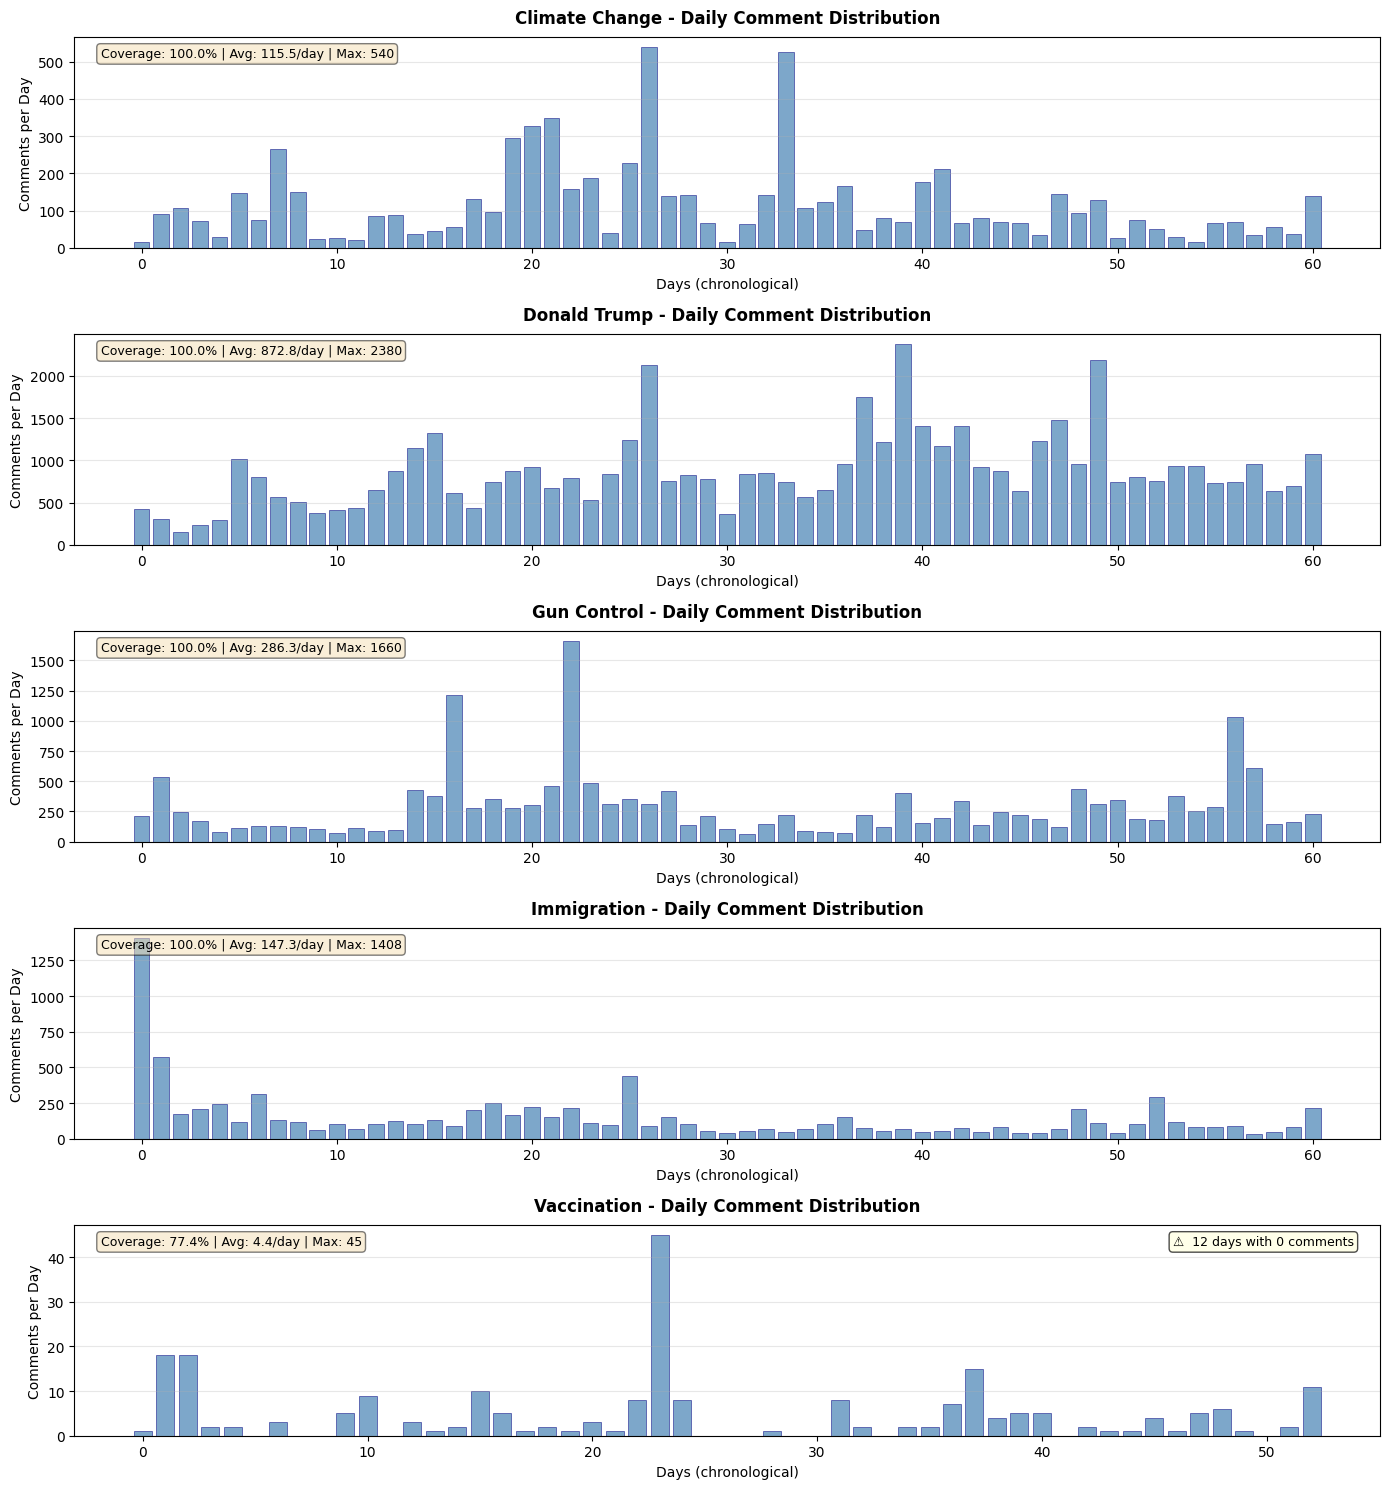

✓ Saved temporal distribution plot: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/temporal_distribution_per_topic.png


In [29]:
# Visualize temporal distribution per topic
import matplotlib.pyplot as plt
import seaborn as sns

print("\nGenerating temporal distribution plots...")

fig, axes = plt.subplots(len(topic_ids), 1, figsize=(14, 3 * len(topic_ids)))
if len(topic_ids) == 1:
    axes = [axes]

for idx, topic_id in enumerate(topic_ids):
    topic_comments = df_comments_final[df_comments_final['thread_topic'] == topic_id]
    topic_label = topic_definitions[topic_id]['label']
    
    if len(topic_comments) > 0:
        ax = axes[idx]
        
        # Daily comment counts
        daily_counts = topic_comments.groupby('date').size()
        dates_full = pd.date_range(start=daily_counts.index.min(), end=daily_counts.index.max(), freq='D')
        daily_counts_full = daily_counts.reindex(dates_full.date, fill_value=0)
        
        # Plot
        ax.bar(range(len(daily_counts_full)), daily_counts_full.values, 
               color='steelblue', alpha=0.7, edgecolor='navy', linewidth=0.5)
        
        ax.set_title(f'{topic_label} - Daily Comment Distribution', 
                     fontsize=12, fontweight='bold', pad=10)
        ax.set_xlabel('Days (chronological)', fontsize=10)
        ax.set_ylabel('Comments per Day', fontsize=10)
        ax.grid(axis='y', alpha=0.3)
        
        # Add statistics
        coverage_pct = (len(daily_counts) / len(daily_counts_full) * 100)
        stats_text = f'Coverage: {coverage_pct:.1f}% | Avg: {daily_counts_full.mean():.1f}/day | Max: {daily_counts_full.max()}'
        ax.text(0.02, 0.95, stats_text, transform=ax.transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Highlight gaps (days with 0 comments)
        zero_days = (daily_counts_full == 0).sum()
        if zero_days > 0:
            ax.text(0.98, 0.95, f'⚠️  {zero_days} days with 0 comments', 
                    transform=ax.transAxes, fontsize=9, 
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))

plt.tight_layout()
plt.savefig(output_path / 'temporal_distribution_per_topic.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved temporal distribution plot: {output_path / 'temporal_distribution_per_topic.png'}")

In [30]:
# Create summary
summary = {
    'notebook': '15b_hybrid_reddit_topic_assignment',
    'approach': 'hybrid_thread_aware',
    'timestamp': datetime.now().isoformat(),
    'threshold': THRESHOLD,
    'model': model_name,
    'input_data': {
        'total_submissions': len(df_submissions),
        'total_comments': len(df_comments)
    },
    'thread_level_results': {
        'submissions_with_topic': int(df_submissions['thread_topic'].notna().sum()),
        'submissions_with_topic_pct': float(df_submissions['thread_topic'].notna().sum() / len(df_submissions) * 100),
        'topic_distribution': {
            topic_definitions[tid]['label']: int((df_submissions['thread_topic'] == tid).sum())
            for tid in topic_ids
        }
    },
    'comment_level_results': {
        'comments_in_topic_threads': len(df_comments_filtered),
        'comments_passing_hybrid_filter': len(df_comments_final),
        'overall_retention_pct': float(len(df_comments_final) / len(df_comments) * 100),
        'hybrid_pass_rate_pct': float(len(df_comments_final) / len(df_comments_filtered) * 100),
        'topic_distribution': {
            topic_definitions[tid]['label']: int((df_comments_final['thread_topic'] == tid).sum())
            for tid in topic_ids
        }
    },
    'outputs': {
        'submissions': str(submissions_output),
        'comments': str(comments_output)
    }
}

# Save summary
summary_file = output_path / '15b_hybrid_topic_assignment_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print("=" * 80)
print("HYBRID TOPIC ASSIGNMENT COMPLETE")
print("=" * 80)

print(f"\nInput:")
print(f"  Submissions: {len(df_submissions):,}")
print(f"  Comments: {len(df_comments):,}")

print(f"\nThread-Level (Step 1):")
print(f"  Submissions with topics: {df_submissions['thread_topic'].notna().sum():,} ({df_submissions['thread_topic'].notna().sum()/len(df_submissions)*100:.1f}%)")

print(f"\nComment-Level (Step 2):")
print(f"  Comments in topic threads: {len(df_comments_filtered):,}")
print(f"  Comments passing hybrid filter: {len(df_comments_final):,}")
print(f"  Overall retention: {len(df_comments_final)/len(df_comments)*100:.2f}%")

print(f"\nOutput Files:")
print(f"  {submissions_output}")
print(f"  {comments_output}")
print(f"  {summary_file}")

print(f"\n" + "=" * 80)
print("✓ Ready for stance annotation sampling (16a)")
print("=" * 80)

HYBRID TOPIC ASSIGNMENT COMPLETE

Input:
  Submissions: 923,431
  Comments: 8,698,923

Thread-Level (Step 1):
  Submissions with topics: 98,178 (10.6%)

Comment-Level (Step 2):
  Comments in topic threads: 1,281,542
  Comments passing hybrid filter: 86,974
  Overall retention: 1.00%

Output Files:
  /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/submissions_with_topics_hybrid.parquet
  /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/comments_with_topics_hybrid.parquet
  /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/02_topics/reddit/15b_hybrid_topic_assignment_summary.json

✓ Ready for stance annotation sampling (16a)
